In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
from datetime import datetime
import tensorflow as tf

/opt/homebrew/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/var/folders/mb/s55_rmmx4gq6kyms8tszjclh0000gn/T/ipykernel_15473/429518820.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
#clean up data for
data = pd.read_csv('full_data.csv')
data['Date'] = pd.to_datetime(data['Date'])

btc = data.loc[data['Crypto']=='BTC']
btc = btc.drop('Unnamed: 0', axis=1)
btc = btc.sort_values(by='Date')
btc = btc.reset_index(drop=True)
btc = btc.drop(['Crypto'],axis=1)
btc = btc.set_index('Date')

eth = data.loc[data['Crypto']=='ETH']
eth = eth.drop('Unnamed: 0', axis=1)
eth = eth.sort_values(by='Date')
eth = eth.reset_index(drop=True)
eth = eth.drop(['Crypto'],axis=1)
eth = eth.set_index('Date')

ltc = data.loc[data['Crypto']=='LTC']
ltc = ltc.sort_values(by='Date')
ltc = ltc.drop('Unnamed: 0', axis=1)
ltc = ltc.reset_index(drop=True)
ltc = ltc.drop(['Crypto'],axis=1)
ltc = ltc.set_index('Date')

#train for optimization only till then
btc = btc.loc[btc.index<=datetime(2022,5,31)]
eth = eth.loc[eth.index<=datetime(2022,5,31)]
ltc = ltc.loc[ltc.index<=datetime(2022,5,31)]

In [3]:
def calculate_rsi(prices, window=40):
    # Calculate the price differences
    delta = prices.diff()

    # Separate gains and losses
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate the average gain and loss
    avg_gain = gain.rolling(window=window, min_periods=40).mean()
    avg_loss = loss.rolling(window=window, min_periods=40).mean()

    # Calculate the relative strength (RS)
    rs = avg_gain / avg_loss

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))

    return rsi

def transform_prices(df, window=60):
    df['Returns'] = df['Close'].pct_change()    
    df['MovingAverage'] = df['Close'].rolling(window=60).mean()
    df['Volatility'] = df['Returns'].rolling(window=60).std() * np.sqrt(60)
    df['RSI'] = calculate_rsi(df['Close'])

    # Creating the momentum feature
    df['Momentum'] = df['Close'] - df['MovingAverage']
    df['Momentum'] /= df['MovingAverage'] * df['Volatility']

    # Droping features which the function should not append
    df = df.drop(columns=['MovingAverage'])
    df = df.dropna()

    return df


btc = transform_prices(btc)
eth = transform_prices(eth)
ltc = transform_prices(ltc)

In [4]:
#function to split X
def ts_split(ts, feature_steps, target_steps):
    n_obs = len(ts) - feature_steps - target_steps + 1
    X = np.array([ts[idx:idx + feature_steps] for idx in range(n_obs)])
    return X
# Forecasting target t+n days ahead
def ts_split_y(ts, feature_steps, target_steps):
    n_obs = len(ts) - feature_steps - target_steps + 1
    y = np.array([ts[idx + feature_steps + target_steps - 1]
                  for idx in range(n_obs)])
    return y

In [179]:
value_features = 20 #we use last 20 days 
value_target = 5 #to forecast 5 days ahead
#split the data for all 3 assets
btc_open = ts_split(np.array(btc['Open']), feature_steps = value_features, target_steps = value_target)
btc_high = ts_split(np.array(btc['High']), feature_steps = value_features, target_steps = value_target)
btc_low = ts_split(np.array(btc['Low']), feature_steps = value_features, target_steps = value_target)
btc_close = ts_split(np.array(btc['Close']), feature_steps = value_features, target_steps = value_target)
btc_ret = ts_split(np.array(btc['Returns']), feature_steps = value_features, target_steps = value_target)
btc_vol = ts_split(np.array(btc['Volatility']), feature_steps = value_features, target_steps = value_target)
btc_rsi = ts_split(np.array(btc['RSI']), feature_steps = value_features, target_steps = value_target)
btc_mom = ts_split(np.array(btc['Momentum']), feature_steps = value_features, target_steps = value_target)

eth_open = ts_split(np.array(eth['Open']), feature_steps = value_features, target_steps = value_target)
eth_high = ts_split(np.array(eth['High']), feature_steps = value_features, target_steps = value_target)
eth_low = ts_split(np.array(eth['Low']), feature_steps = value_features, target_steps = value_target)
eth_close = ts_split(np.array(eth['Close']), feature_steps = value_features, target_steps = value_target)
eth_ret = ts_split(np.array(eth['Returns']), feature_steps = value_features, target_steps = value_target)
eth_vol = ts_split(np.array(eth['Volatility']), feature_steps = value_features, target_steps = value_target)
eth_rsi = ts_split(np.array(eth['RSI']), feature_steps = value_features, target_steps = value_target)
eth_mom = ts_split(np.array(eth['Momentum']), feature_steps = value_features, target_steps = value_target)

ltc_open = ts_split(np.array(ltc['Open']), feature_steps = value_features, target_steps = value_target)
ltc_high = ts_split(np.array(ltc['High']), feature_steps = value_features, target_steps = value_target)
ltc_low = ts_split(np.array(ltc['Low']), feature_steps = value_features, target_steps = value_target)
ltc_close = ts_split(np.array(ltc['Close']), feature_steps = value_features, target_steps = value_target)
ltc_ret = ts_split(np.array(ltc['Returns']), feature_steps = value_features, target_steps = value_target)
ltc_vol = ts_split(np.array(ltc['Volatility']), feature_steps = value_features, target_steps = value_target)
ltc_rsi = ts_split(np.array(ltc['RSI']), feature_steps = value_features, target_steps = value_target)
ltc_mom = ts_split(np.array(ltc['Momentum']), feature_steps = value_features, target_steps = value_target)

#Target var of predicting price t+n days ahead
y_btc = ts_split_y(np.array(btc['Close']), feature_steps = value_features, target_steps = value_target)
y_eth = ts_split_y(np.array(eth['Close']), feature_steps = value_features, target_steps = value_target)
y_ltc = ts_split_y(np.array(ltc['Close']), feature_steps = value_features, target_steps = value_target)

In [180]:
#create the features matrix
combined_array = np.stack((btc_open, btc_high , btc_low, btc_close, btc_ret, btc_vol, btc_rsi, btc_mom), axis=1)
X = combined_array

In [181]:
# Determine the size of the validation set
train_idx = round(len(X)*0.8)
X_train_full= X[:train_idx] ## all same for each model

#test data for X and y targets
X_test= X[train_idx:]
y_test_btc = y_btc[train_idx:]

val_idx = round(train_idx * 0.1)  # 10% of the training set
train_idx_final = train_idx - val_idx

# Split the training data into training and validation sets
X_train = X_train_full[:train_idx_final]
X_val = X_train_full[train_idx_final:train_idx]

#train and validation for targets
y_train_btc = y_btc[:train_idx_final]
y_val_btc = y_btc[train_idx_final:train_idx]

#reshape and convert all into pandas series
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_train_reshaped = pd.DataFrame(X_train_reshaped)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
X_val_reshaped = pd.DataFrame(X_val_reshaped)

y_train_btc = pd.DataFrame(y_train_btc)
y_val_btc = pd.DataFrame(y_val_btc)

#reshape  test
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
X_test_reshaped = pd.DataFrame(X_test_reshaped)

y_test_btc_reshaped = y_test_btc.reshape(y_test_btc.shape[0], -1)
y_test_btc_reshaped = pd.DataFrame(y_test_btc_reshaped)

In [182]:
import tensorflow as tf

def rolling_pct_diff_loss(y_true, y_pred, window):
    epsilon = tf.keras.backend.epsilon()
    
    # Calculate percentage difference
    pct_diff = tf.abs((y_true - y_pred) / (tf.abs(y_true) + epsilon))
    
    # Apply rolling window only if there are enough values
    def rolling_window(x):
        return tf.cond(
            tf.shape(x)[0] >= window,
            lambda: tf.reduce_mean(tf.signal.frame(x, window, 1, axis=0), axis=-1),
            lambda: x  # If not enough values, return the original values
        )
    
    # Apply rolling window to the percentage differences
    rolling_pct_diff = rolling_window(pct_diff)
    
    # Return mean of rolling percentage differences
    return tf.reduce_mean(rolling_pct_diff)


In [219]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.initializers import HeNormal
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()
initializer = HeNormal()

# Fit the scaler on the training data and transform both the training and validation data
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_val_scaled = scaler.transform(X_val_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Function to reset the TensorFlow session
def reset_session(seed=42):
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    tf.random.set_seed(seed)
    np.random.seed(seed)

# Reset the session
reset_session()
nuerons = 35
activation = "relu"
l2_reg = 0.00025270483570026075
# Define the DNN model
model = Sequential([
    Dense(nuerons, activation=activation, input_shape=(X_train_scaled.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, input_shape=(X_train_scaled.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, input_shape=(X_train_scaled.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, input_shape=(X_train_scaled.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, input_shape=(X_train_scaled.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, input_shape=(X_train_scaled.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),

    Dense(1)
])
# Compile the model
optimizer = Adam(learning_rate=0.00012337256785879854)
model.compile(loss=lambda y_true, y_pred: rolling_pct_diff_loss(y_true, y_pred, window=10), optimizer=optimizer, metrics=[lambda y_true, y_pred: rolling_pct_diff_loss(y_true, y_pred, window=10)])
#model.compile(loss="mse", optimizer=optimizer, metrics=["mse"])

# Train the model
history = model.fit(X_train_scaled, y_train_btc, epochs=50, validation_data=(X_val_scaled, y_val_btc))

Epoch 1/50


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - lambda: 1.0000 - loss: 1.0582 - val_lambda: 1.0000 - val_loss: 1.0560
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - lambda: 1.0000 - loss: 1.0553 - val_lambda: 1.0000 - val_loss: 1.0532
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - lambda: 1.0000 - loss: 1.0525 - val_lambda: 1.0000 - val_loss: 1.0505
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - lambda: 1.0000 - loss: 1.0499 - val_lambda: 1.0000 - val_loss: 1.0480
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - lambda: 1.0000 - loss: 1.0474 - val_lambda: 1.0000 - val_loss: 1.0456
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - lambda: 1.0000 - loss: 1.0450 - val_lambda: 1.0000 - val_loss: 1.0433
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - lambda: 1.0000 - loss: 1.0427 - val_lambda: 1.0000 - val_loss: 1.0411
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - lambda: 1.0000 - loss: 1.0405 - val_lambda: 1.0000 - val_loss: 1.0390
Epoch 9/50
35/35 ━━━━━━

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step


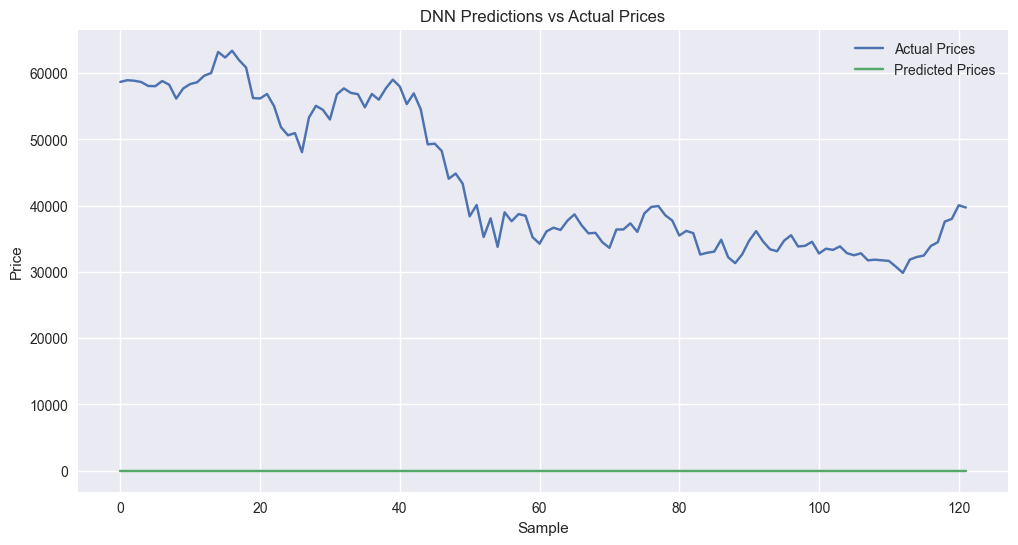

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step


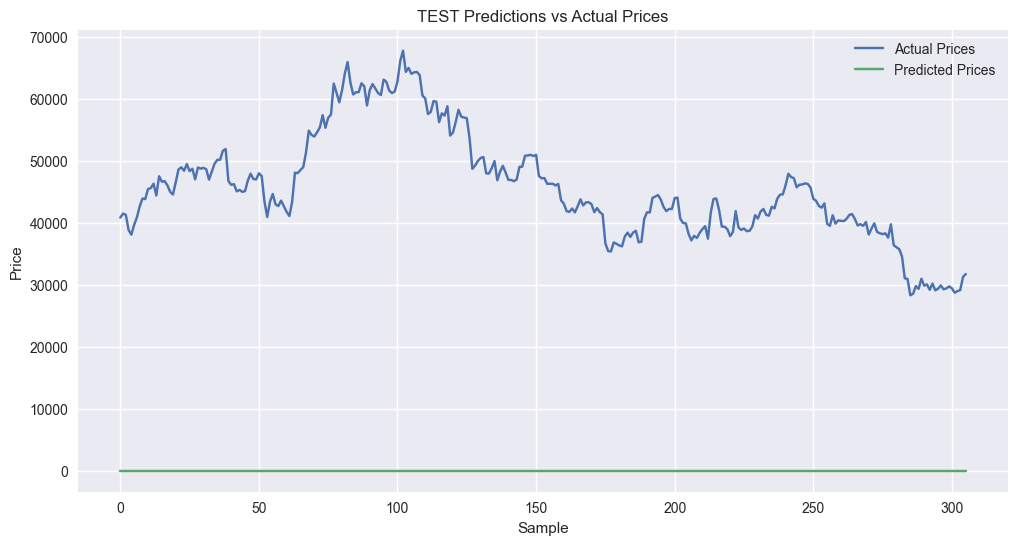

In [221]:
# Make predictions
y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)

# Plot the predictions vs actual values for validation set
plt.figure(figsize=(12, 6))
plt.plot(y_val_btc, label='Actual Prices')
plt.plot(y_val_pred, label='Predicted Prices')
plt.title('DNN Predictions vs Actual Prices')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.legend()
plt.show()

# Make predictions
y_test_pred = model.predict(X_test_scaled)

# Plot the predictions vs actual values for validation set
plt.figure(figsize=(12, 6))
plt.plot(y_test_btc, label='Actual Prices')
plt.plot(y_test_pred, label='Predicted Prices')
plt.title('TEST Predictions vs Actual Prices')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.legend()
plt.show()

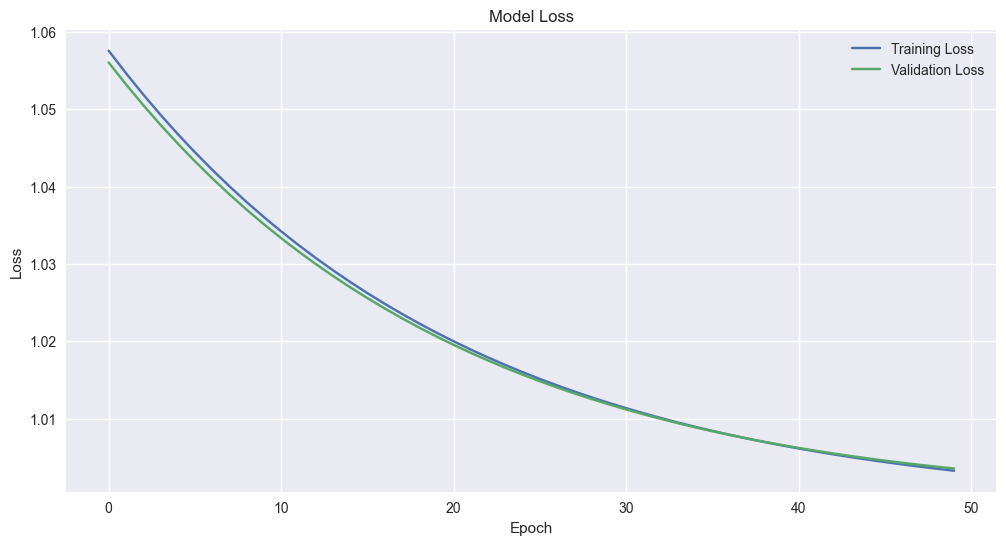

In [222]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [223]:
np.mean(np.sign(pd.DataFrame(y_test_pred).diff().dropna()) == np.sign(pd.DataFrame(y_test_btc).diff().dropna()))

/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


0    0.55082
dtype: float64

In [215]:
import tensorflow as tf

def rolling_pct_diff_loss(y_true, y_pred, window):
    epsilon = tf.keras.backend.epsilon()
    
    # Calculate percentage difference
    pct_diff = tf.abs((y_true - y_pred) / (tf.abs(y_true) + epsilon))
    
    # Apply rolling window only if there are enough values
    def rolling_window(x):
        return tf.cond(
            tf.shape(x)[0] >= window,
            lambda: tf.reduce_mean(tf.signal.frame(x, window, 1, axis=0), axis=-1),
            lambda: x  # If not enough values, return the original values
        )
    
    # Apply rolling window to the percentage differences
    rolling_pct_diff = rolling_window(pct_diff)
    
    # Return mean of rolling percentage differences
    return tf.reduce_mean(rolling_pct_diff)

In [216]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Nadam
import keras_tuner as kt
import tensorflow as tf

def reset_session(seed=42):
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    tf.random.set_seed(seed)
    np.random.seed(seed)

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=5, max_value=30, default=2)
    n_neurons = hp.Int("n_neurons", min_value=1, max_value=100)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    l2_reg = hp.Float("l2_reg", min_value=1e-4, max_value=100, sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "Nadam", "Adam"])
    activation = hp.Choice("activation", values=["relu", "swish"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, clipnorm=1.0)
    else:
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=X_train_scaled.shape[1:]))
    model.add(tf.keras.layers.Normalization())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss=lambda y_true, y_pred: rolling_pct_diff_loss(y_true, y_pred, window=10), optimizer=optimizer, metrics=[lambda y_true, y_pred: rolling_pct_diff_loss(y_true, y_pred, window=10)])

    return model

In [217]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_loss", max_trials=50, overwrite=True,
    directory="BTC", project_name="my_rnd_search", seed=42)
random_search_tuner.search(X_train_scaled, y_train_btc, epochs=100,
                           validation_data=(X_val_scaled, y_val_btc))

Trial 50 Complete [00h 00m 09s]
val_loss: 0.9999239444732666

Best val_loss So Far: 0.1687510758638382
Total elapsed time: 00h 10m 33s


In [218]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
best_params = top3_params[0].values

print(f"Best hyperparameters: {best_params}")

/opt/homebrew/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 31 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/opt/homebrew/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 107 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best hyperparameters: {'n_hidden': 6, 'n_neurons': 35, 'learning_rate': 0.00012337256785879854, 'l2_reg': 0.00025270483570026075, 'optimizer': 'Adam', 'activation': 'relu'}


/opt/homebrew/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 79 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
